# Detecting Simpson's Pardox and other Surprising things in data

How can we detect it?
WHat is it? 
WHy is it harder in large

How can it be interactive and do epople have intutition for it?



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

It's generally discussed in terms of two variables, both discrete, though binary or mulit level cases are both poputlar.  A popular example is the berkeley admissions data set.  the claim was that it was iased againt women because t the univerisyt sclae it ws, but fom os depeartments they actually admitted wmen at much higher rates  but the departments tha had low aceptance rates wer the ones with most of the women applicants

# Regression Based SImpson's Paradox


It can manifest in how a decision variable relates to others that $x_k$ is predicted differently for different values of $x_j$ 
another way Simpson's Paradox could manifest is through latent clusters.  It can manifest in relationsships among variables.  

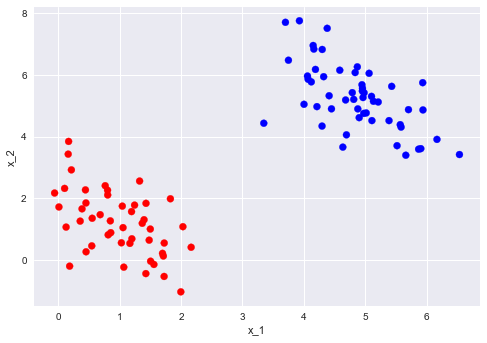

In [2]:
# 
N = 100
# sample data from 2 clusters
mu = np.asarray([[1,1],[5,5]])

z = np.random.randint(0,2,N)
x = np.asarray([np.random.multivariate_normal(mu[z_i],[[.6,-1],[0,.6]]) for z_i in z])

latent_df = pd.DataFrame(data=x,
                       columns = ['x1', 'x2'])
# third attribute
x3 = np.random.normal(0, 10, N)
latent_df['x3'] = x3

# now we add somoe more columns
color_z = {0:'r', 1:'b'}
char_zy = {0: {0:'x', 1:'o'}, 1:{0:'o', 1:'x'}}

latent_df['color'] = [color_z[z_i] for z_i in z]
y = np.random.choice([0,1],N,p=[.7,.3])
#latent_df['y'] = y
latent_df['char'] = [char_zy[zi][yi] for zi,yi in zip(z,y)]

plt.scatter(latent_df['x1'], latent_df['x2'],
            c =  latent_df['color'], marker= 'o')
#plt.scatter(clust_x['x1'], clust_x['x2'],
          #  c =  clust_x['color'], marker= 'x')
plt.xlabel('x_1')
plt.ylabel('x_2')
# , marker = 'char' , c = 'color'
plt.show()

in this, if we ignore the color, x_1 and x_2 are posiiely correlated, but in each color, they're negatively correlated.  

In [7]:
#latent_df['x1'].corr(latent_df['x2'])
corrAll=latent_df.corr()
print(corrAll)

          x1        x2        x3
x1  1.000000  0.759899  0.036851
x2  0.759899  1.000000  0.032104
x3  0.036851  0.032104  1.000000


Compute all subgroup correlation matrix respectively.

In [11]:
# group by color
grouped_df_color = latent_df.groupby('color')['x1','x2','x3'].corr()
blue=grouped_df_color.loc['b']
red=grouped_df_color.loc['r']
print("Subgroup for blue color:")
print(blue)
print("Subgroup for red color:")
print(red)

# group by char
grouped_df_char = latent_df.groupby('char')['x1','x2','x3'].corr()
char_o=grouped_df_char.loc['o']
char_x=grouped_df_char.loc['x']
print("Subgroup for char_o:")
print(char_o)
print("Subgroup for char_x:")
print(char_x)

Subgroup for blue color:
          x1        x2        x3
x1  1.000000 -0.607329 -0.114757
x2 -0.607329  1.000000 -0.004444
x3 -0.114757 -0.004444  1.000000
Subgroup for red color:
          x1        x2        x3
x1  1.000000 -0.527607 -0.057612
x2 -0.527607  1.000000 -0.123809
x3 -0.057612 -0.123809  1.000000
Subgroup for char_o:
          x1        x2        x3
x1  1.000000  0.749464 -0.017089
x2  0.749464  1.000000 -0.083506
x3 -0.017089 -0.083506  1.000000
Subgroup for char_x:
          x1        x2        x3
x1  1.000000  0.749065  0.042554
x2  0.749065  1.000000  0.119797
x3  0.042554  0.119797  1.000000


So, we can see that the correlation between $x_1$ and $x_2$ is positive in the whole data set and negative in each subgroup.  This is Simpson's paradox. So, to detect Simpson's Paradox in a data set with $d$ continuous variables and $c$ discrete variables, we can compute correlation matrix for all of the data, one $d \times d$ matrix.  Then for each of the $c$ discrete variables with $k_c$ levels we compute an additional $d \times d$ matrix$ for each level of each variable.  

So, we need to compute $1+ \sum_{i = 1}^c k_i$ correlation matrices of size $d \times d$ and compare the signs of each element in the lower half of all the $\sum_{i = 1}^c k_i$ for subgroup levels to the first one. 

# Combine all correlation matrix together
Put all correlation matrix and subgroup correlation in the diagnal and make up the rest area of a combined matrix by 0 matrix.

In [12]:
# create a 0 matrix for the irrelvant cells
s = (len(blue),len(blue))
zero = np.zeros(s)

# manipulate the subgroup matrix first after corr() method
color_group=np.vstack([np.hstack([blue, zero]), np.hstack([zero, red])])

# create a 0 matrix for the irrelvant cells
s = (len(corrAll),len(color_group))
zero1 = np.zeros(s)

# combine the correlation matrix of all of the data with subgroup by color
all_combined=np.vstack([np.hstack([corrAll, zero1]), np.hstack([zero1.transpose(), color_group])])

# Combine char group
s = (len(char_o),len(char_x))
zero = np.zeros(s)
char_group=np.vstack([np.hstack([char_o, zero]), np.hstack([zero, char_x])])
s = (len(all_combined),len(char_group))
zero1 = np.zeros(s)
all_combined=np.vstack([np.hstack([all_combined, zero1]), np.hstack([zero1.transpose(), char_group])])

[[ 1.          0.75989942  0.03685063  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.75989942  1.          0.03210402  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.03685063  0.03210402  1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          1.         -0.60732868 -0.11475655
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.         -0.60732868  1.         -0.00444443
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.         -0.11475655 -0.00444443  1.          0.
   0.          0.          0.          0.          

We will see a combined matrix by seaborn.heatmap

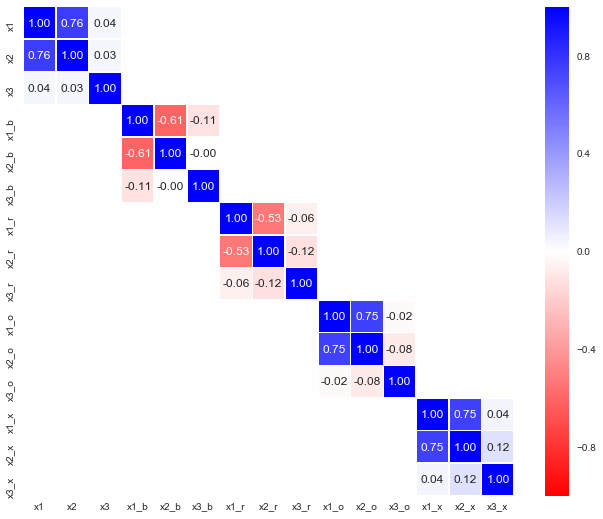

In [6]:
# Generate a heatmap for correlation matrix
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', ['red', 'white', 'blue'])
norm = plt.Normalize(-1,1)

# labels are generated by attributes with subgroup's notation
labels =  ['x1','x2','x3','x1_b','x2_b','x3_b','x1_r','x2_r','x3_r','x1_o','x2_o','x3_o','x1_x','x2_x','x3_x']
plt.figure(figsize=(11, 9))

ax = sns.heatmap(all_combined, cmap=cmap, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, linewidths=.5, norm=norm, center=0)

# Offset 0.00
for t in ax.texts: 
    if t.get_text() == '0.00':
        t.set_text("")
plt.show()